In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv("parkingLot.csv")

# Strip whitespaces and replace empty strings with NaN
data_pro = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
data_pro.replace('', np.nan, inplace=True)
data_pro.columns=data_pro.columns.str.strip()

# Drop null/empty values
data_pro=data_pro.dropna(axis=0)

data_pro['date']=data_pro['timestamp'].apply(lambda x: x[:11])
data_pro['#date']=pd.Categorical(data_pro['date']).codes+1
data_pro['#week']=(data_pro['#date']-1)//7 +1
data_pro=data_pro[data_pro['#week']!=10] # drop the day 64, 12 AM data()

data_pro['time']=data_pro['timestamp'].apply(lambda x: x[11:])
data_pro['time']=pd.to_timedelta(data_pro['time']).dt.total_seconds()/3600
data_pro=data_pro[data_pro['time']>=5]
data_pro=data_pro[data_pro['time']<=24]

data_pro['period of the day'] = pd.cut(data_pro['time'], bins=[5,8,11, 14, 17, 20, 24], labels=['Early morning', 'Late morning', 'Midday', 'Afternoon', 'Evening', 'Late Night'], right=False)

data_entry=data_pro[data_pro['camera_id']==1]
data_exit=data_pro[data_pro['camera_id']==2]


#### PART 1A

(52976, 8) (52022, 8)


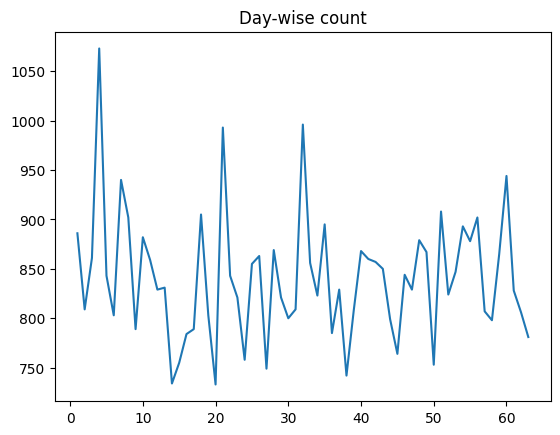

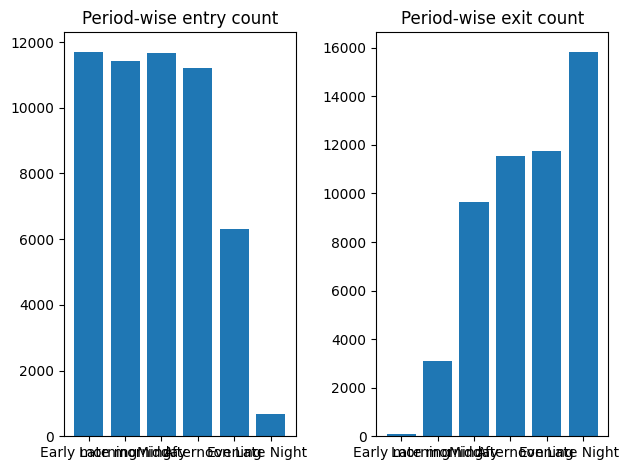

In [2]:
import matplotlib.pyplot as plt
# Count the occurrences of each date
daily_counts = data_entry['#date'].value_counts().sort_index()
period_wise_entry_counts=data_entry['period of the day'].value_counts().sort_index()
period_wise_exit_counts=data_exit['period of the day'].value_counts().sort_index()
print(data_entry.shape, data_exit.shape)

# Plot the bar chart
# print(day_counts.describe())
plt.plot(daily_counts.index, daily_counts.values)
# plt.yticks(np.arange(1000, 2400, 200))
plt.title("Day-wise count")
plt.show()

# Plot the bar chart
plt.subplot(1,2,1)
plt.bar(period_wise_entry_counts.index, period_wise_entry_counts.values)
plt.title("Period-wise entry count")

plt.subplot(1,2,2)
plt.bar(period_wise_exit_counts.index, period_wise_exit_counts.values)
plt.title("Period-wise exit count")
plt.tight_layout()

In [3]:
# Trying to find a pattern in the daily count
date_with_lows=daily_counts[daily_counts<1500]
date_with_highs=daily_counts[daily_counts>1800]
print(date_with_highs, date_with_lows)


Series([], Name: count, dtype: int64) #date
1      886
2      809
3      861
4     1073
5      843
      ... 
59     865
60     944
61     828
62     806
63     781
Name: count, Length: 63, dtype: int64


In [4]:
# Train-test split
train_size = int(0.6 * len(daily_counts)) # day_counts is only 63 data long T-T
train, test = daily_counts[:train_size], daily_counts[train_size:]

P value:  1.0295273993242231e-07


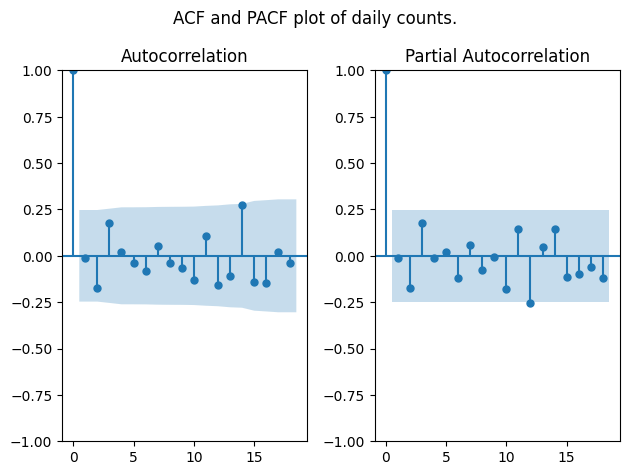

In [5]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Augmented Dickey-Fuller test to test stationarity
ADF_statistic, p_value = sm.tsa.stattools.adfuller(train)[0:2]
# print(ADF_statistic, p_value)
print("P value: ", p_value)

# Plotting ACF and PACF
layout = (1, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))

smt.graphics.plot_acf(daily_counts, ax=acf_ax)
smt.graphics.plot_pacf(daily_counts, ax=pacf_ax)
plt.suptitle(f"ACF and PACF plot of daily counts.")
plt.tight_layout()

P value:  2.5944631841951305e-08


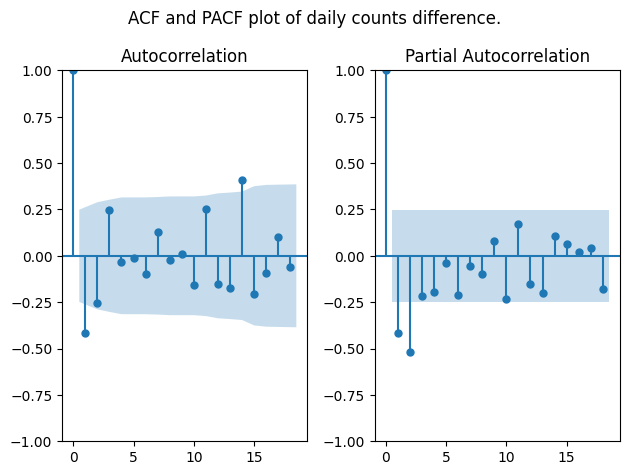

In [6]:
daily_counts_diff=(daily_counts-daily_counts.shift(1)).dropna()
daily_counts_diff2=(daily_counts_diff-daily_counts_diff.shift(1)).dropna()


ADF_statistic, p_value = sm.tsa.stattools.adfuller(daily_counts_diff)[0:2]
# print(ADF_statistic, p_value)
print("P value: ", p_value)

layout = (1, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))

smt.graphics.plot_acf(daily_counts_diff, ax=acf_ax)
smt.graphics.plot_pacf(daily_counts_diff, ax=pacf_ax)
plt.suptitle("ACF and PACF plot of daily counts difference.")
plt.tight_layout()

### It got worse with taking difference. This confirms there is no trend (increasing/decreasing) in the daily counts.

Using ARIMA model

c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib

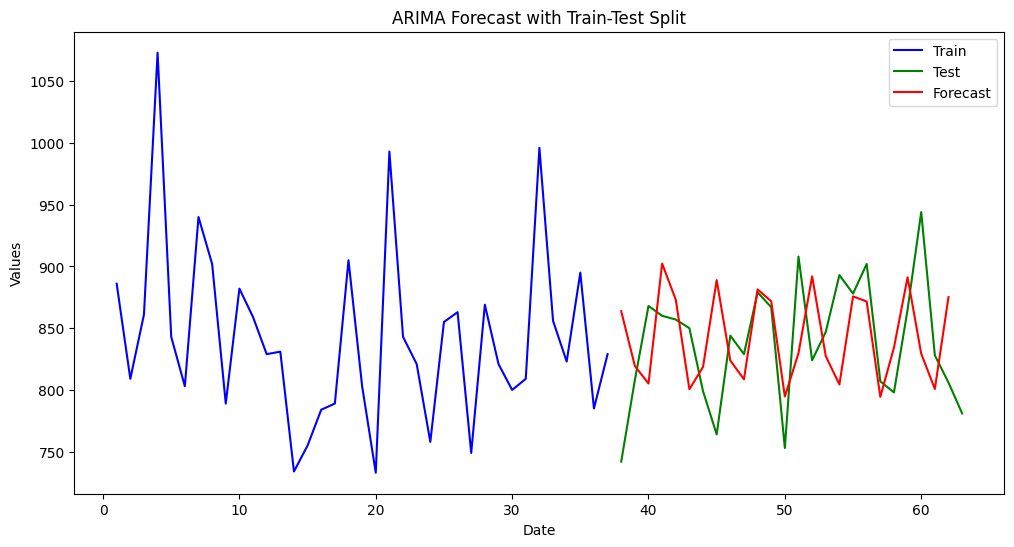

MASE:  0.5502754397180466  MAPE:  0.05470288109058829


In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sktime.performance_metrics.forecasting import (mean_absolute_error, mean_absolute_scaled_error, mean_absolute_percentage_error)


# Fit the ARIMA model
model = ARIMA(train, order=(7, 0, 7))  # Adjust (p, d, q) as necessary
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=len(test))

# Create a forecast Series with the correct index
forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)

# Plotting the results
plt.figure(figsize=(12, 6))
train.plot(label="Train", color="b")
test.plot(label="Test", color="g")
forecast_series.plot(label="Forecast", color="r")

plt.legend()
plt.title("ARIMA Forecast with Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

mase = mean_absolute_scaled_error(test, forecast, y_train=train)
mape = mean_absolute_percentage_error(test, forecast)
print("MASE: ", mase, " MAPE: ", mape)

Using AUTOARIMA model

MASE:  0.48142166132115854  MAPE:  0.04827408501380458


c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


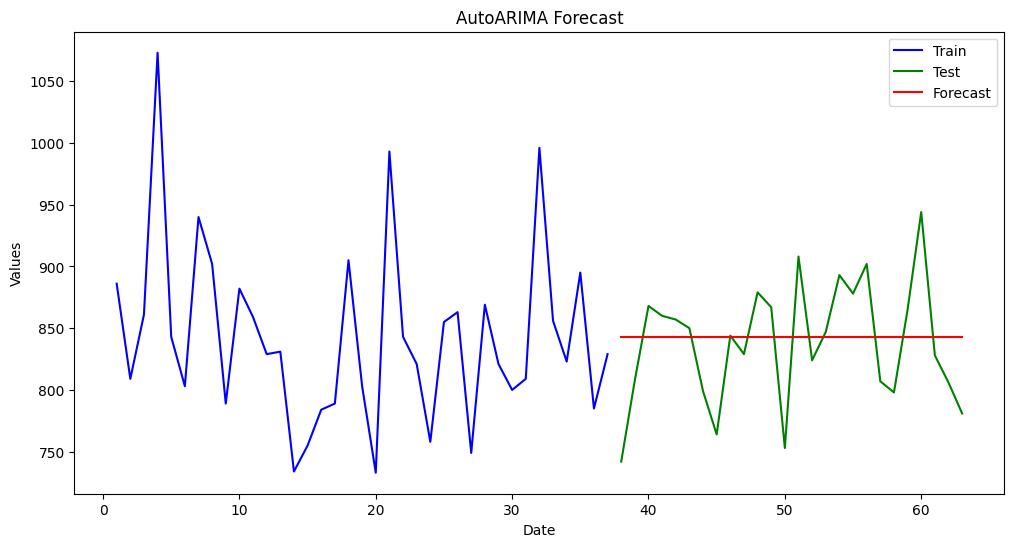

In [8]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(
    suppress_warnings=True,
    start_p=0,
    max_p=7,
    start_q=0,
    max_q=7,
    seasonal=True,
)

# Fit the model
forecaster.fit(train)

# Forecasting
fh = np.arange(1, len(test) + 1)  # Forecast horizon
forecast = forecaster.predict(fh=fh)

# Calculate error metrics
mase = mean_absolute_scaled_error(test, forecast, y_train=train)
mape = mean_absolute_percentage_error(test, forecast)
print("MASE: ", mase, " MAPE: ", mape)

# Plotting the results
plt.figure(figsize=(12, 6))
train.plot(label="Train", color="b")
test.plot(label="Test", color="g")
forecast.index = test.index 
forecast.plot(label="Forecast", color="r")

plt.legend()
plt.title("AutoARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()


Using seasonal ARIMA model

c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Value

MAPE:  0.0538045113667337
MASE:  0.5387267627425651


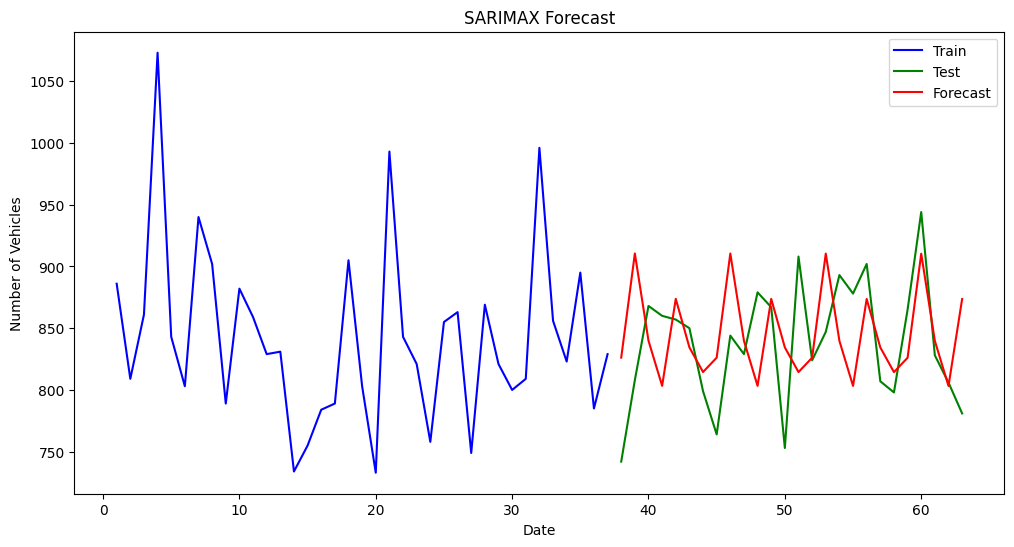

In [9]:
#Trying to fit a seasonal ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMAX model
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))  # Adjust parameters as needed
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Calculate MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculate MASE
mase = mean_absolute_scaled_error(test, forecast, y_train=train)

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
train.plot(label='Train', color='b')
test.plot(label='Test', color='g')
forecast.index = test.index  # Align forecast index
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("SARIMAX Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()

Using ETS model

c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MAPE:  0.05956472709534348
MASE:  0.5957980404899503


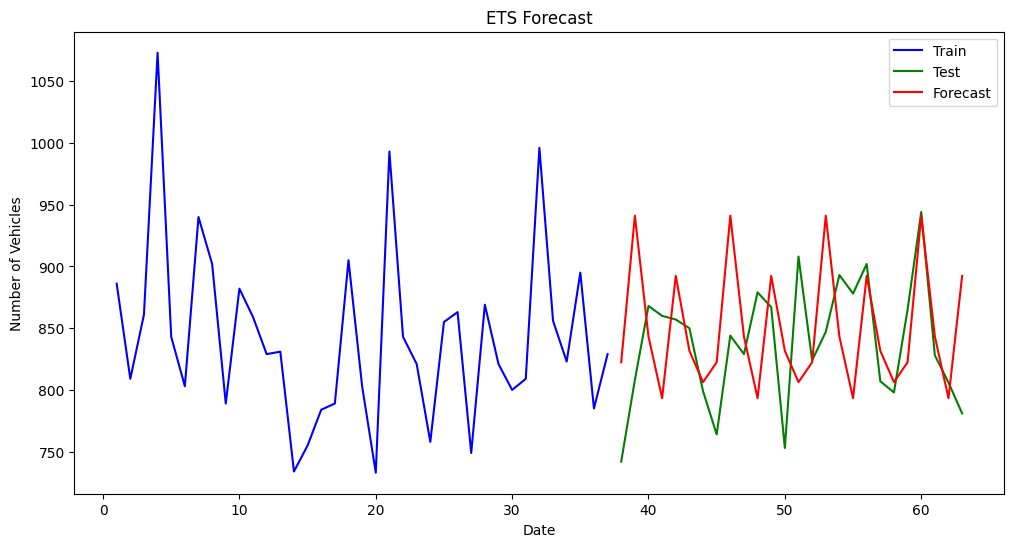

In [10]:
#fitting ETS model 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend=None, seasonal='add', seasonal_periods=7)  # Adjust as needed
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Calculate MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculate MASE 
mase = mean_absolute_scaled_error(test, forecast, y_train=train)

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
train.plot(label='Train', color='b')
test.plot(label='Test', color='g')
forecast.index = test.index 
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("ETS Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()


Doing the final prediction using SARIMA model

c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


predictions for next week (day index starts at 0) 
63    828.359576
64    823.518620
65    820.310092
66    882.762176
67    844.044749
68    825.396430
69    860.909037
Name: predicted_mean, dtype: float64


c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='#date'>

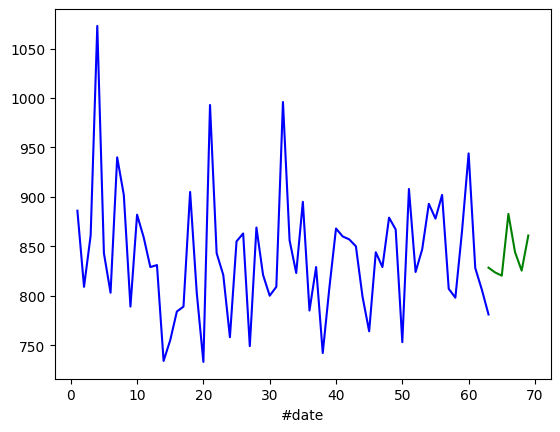

In [11]:
# 1a) Predicting the number of vehicles entering in next 7 days using SARIMA model
pred=np.arange(64, 71)

model = SARIMAX(daily_counts, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))   # Adjust (p, d, q) as necessary
model_fit = model.fit()
pred = model_fit.forecast(steps=len(pred))

print("predictions for next week (day index starts at 0) ")
print(pred)

daily_counts.plot(label='total', color='b')
pred.plot(label='pred', color='g')


#### PART 1B

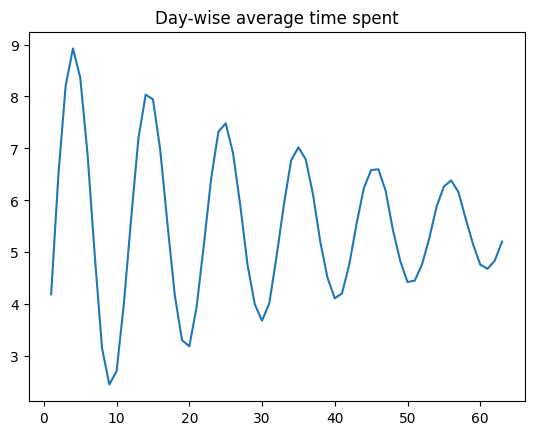

In [12]:

# Merging the data w.r.t vehicle_no. for calculating average time spent etc.
### In the process many data are lost, we try to improve upon this in 1c

entries = data_entry.rename(columns={'time': 'entry_time'})
exits = data_exit.rename(columns={'time': 'exit_time'})
merged_data = pd.merge(entries, exits, on='vehicle_no', how='inner')

# Finding time spent in mall
merged_data['time_spent'] = merged_data['exit_time'] - merged_data['entry_time']

average_time = merged_data.groupby('#date_x')['time_spent'].mean().sort_index()

# Plot the variation of time spent
plt.plot(average_time.index, average_time.values)
plt.title("Day-wise average time spent")
plt.show()


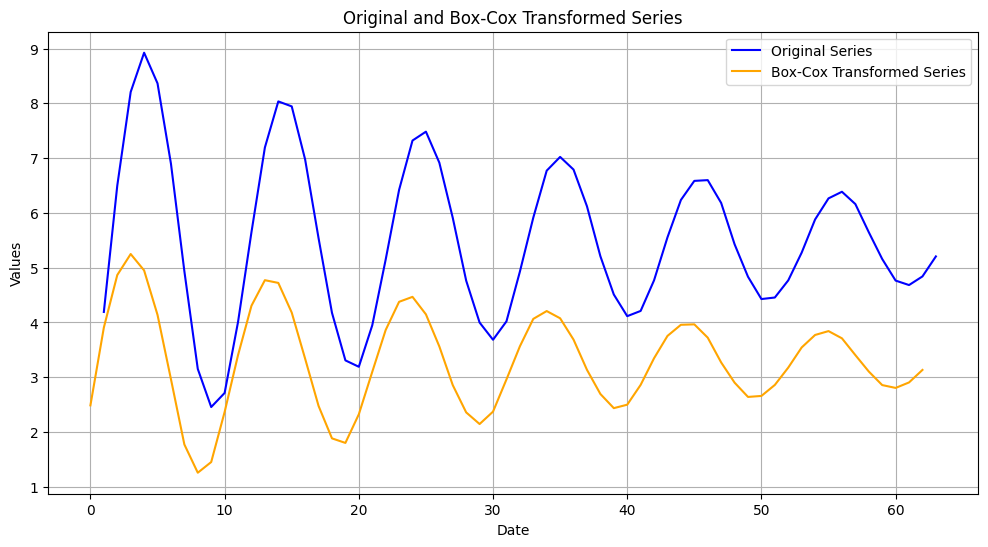

In [13]:
#preprocessing the data to stabilize variance 

from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

series = average_time 

# Apply Box-Cox Transformation to stabilize variance
# Adding a small constant to avoid zero or negative values
transformed_series, lambda_ = boxcox(series)

# Create a new Series for the transformed data
transformed_series = pd.Series(transformed_series)

# Plot the original and Box-Cox transformed series
plt.figure(figsize=(12, 6))
plt.plot(series, label='Original Series', color='blue')
plt.plot(transformed_series, label='Box-Cox Transformed Series', color='orange')
plt.title('Original and Box-Cox Transformed Series')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [14]:

# Check stationarity
result = adfuller(transformed_series.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

## The low value of p confirms stationarity

ADF Statistic: -3.6942950069929723
p-value: 0.004194119350547171


In [15]:

# Train-test split
train_size = int(0.6 * len(transformed_series)) # day_counts is only 63 data long T-T
train, test = transformed_series[:train_size], transformed_series[train_size:]

Using ETS model

MAPE:  0.20575749116836237
MASE:  1.1761267018947015


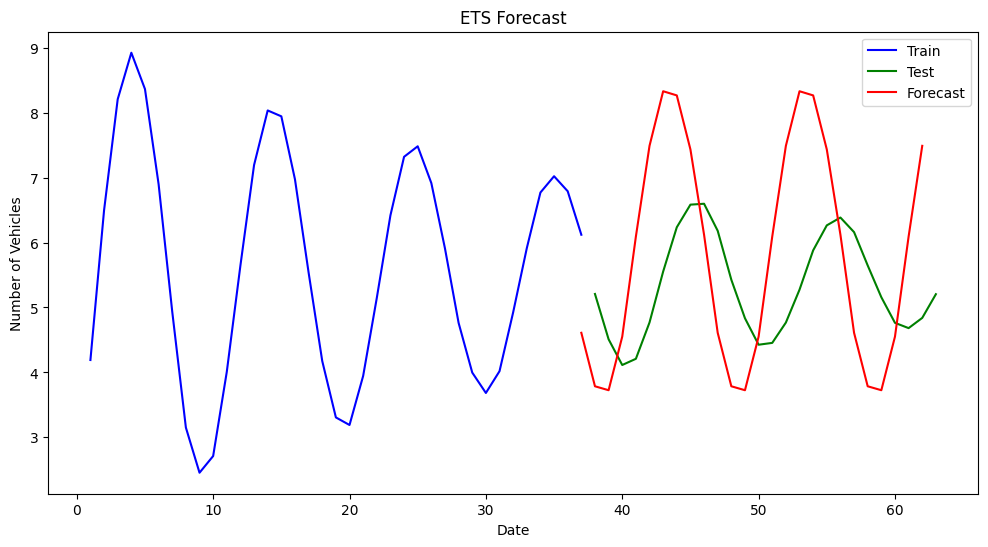

In [16]:

# Fit the ETS model with sesonality of 10
model = ExponentialSmoothing(train, trend=None, seasonal='add', seasonal_periods=10)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Inverse Box-Cox transformation
def inverse_boxcox(y_transformed, lambda_param):
    """
    Inverse Box-Cox transformation.
    Parameters:
    y_transformed : array-like  The transformed values.
    lambda_param : float  The Box-Cox parameter.
        
    Returns:
    y : array-like The original values before transformation.
    """
    if lambda_param == 0:
        return np.exp(y_transformed)
    else:
        return (lambda_param * y_transformed + 1) ** (1 / lambda_param)
    
forecast = inverse_boxcox(forecast, lambda_)  # Reverse the Box-Cox transformation

# Calculate MAPE
mape = mean_absolute_percentage_error(series[train_size:], forecast)

# Calculate MASE 
mase = mean_absolute_scaled_error(series[train_size:], forecast, y_train=series[:train_size])

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
series[:train_size].plot(label='Train', color='b')
series[train_size:].plot(label='Test', color='g')
forecast.index = test.index 
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("ETS Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()


Using SARIMA model

MAPE:  0.029109130200723716
MASE:  0.16070053617145957


c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


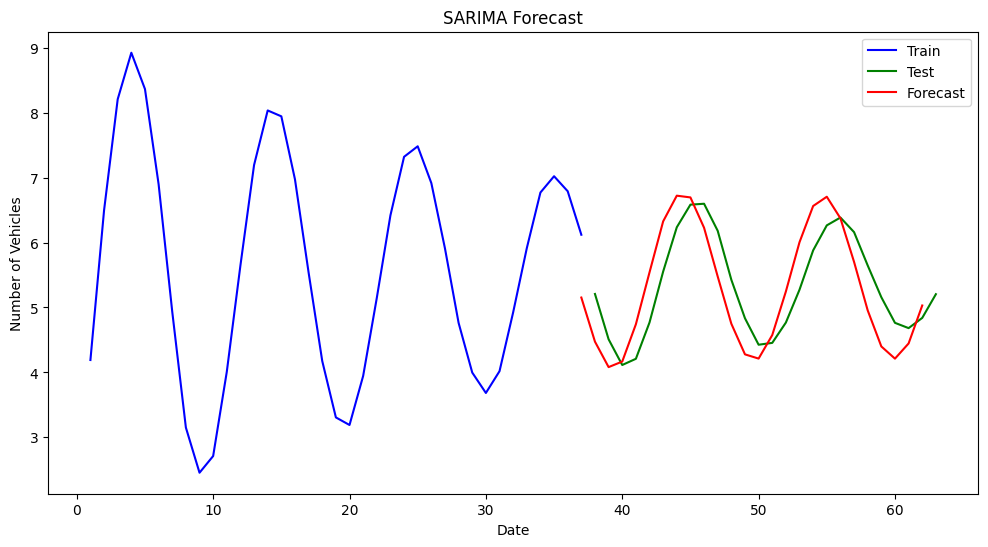

In [17]:
# Fit the Sesonal ARIMA model with sesonality of 10
model = SARIMAX(train, order=(3, 0, 1), seasonal_order=(1, 0, 1, 10))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
forecast = inverse_boxcox(forecast, lambda_)  # Reverse the Box-Cox transformation

# Calculate MAPE
mape = mean_absolute_percentage_error(series[train_size:], forecast)

# Calculate MASE 
mase = mean_absolute_scaled_error(series[train_size:], forecast, y_train=series[:train_size])

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
series[:train_size].plot(label='Train', color='b')
series[train_size:].plot(label='Test', color='g')
forecast.index = test.index 
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()

Predictions for next week

predictions for next week (days indexed from 0)
63    5.796953
64    6.231002
65    6.445560
66    6.381449
67    6.073602
68    5.669879
69    5.283271
Name: predicted_mean, dtype: float64


c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='#date_x'>

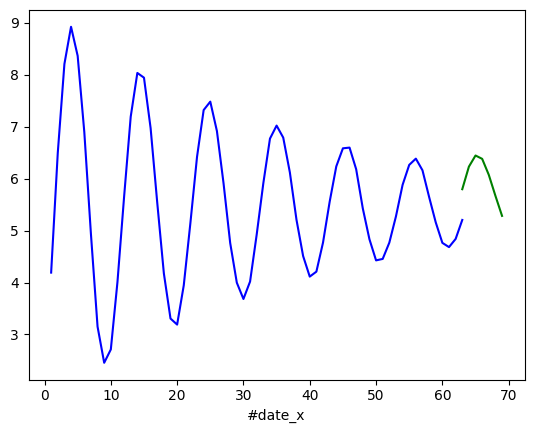

In [18]:
# part 1b) Predict  avg time spent in the mall by a vehicle entering on a particular day, for the next 7 days

pred=np.arange(64, 71)

model = SARIMAX(transformed_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))   # Adjust (p, d, q) as necessary
model_fit = model.fit()
pred = model_fit.forecast(steps=len(pred))
pred = inverse_boxcox(pred, lambda_)  # Reverse the Box-Cox transformation

print("predictions for next week (days indexed from 0)")
print(pred)

series.plot(label='total', color='b')
pred.plot(label='pred', color='g')


#### PART 1C ( For predicting count of vehicles)


##### METHOD - Remove outliers using Z score calculation
Using Seasonal Arima model, the MASE and MAPE have changes as follows:

c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MAPE:  0.05319689411379674
MASE:  0.5475671626554366


c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


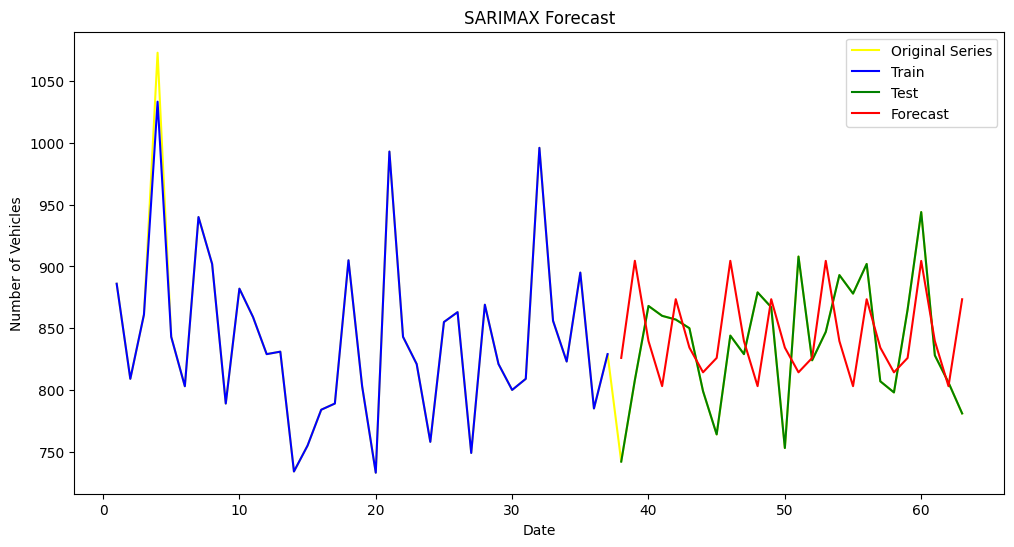

In [19]:

series = daily_counts
# Train-test split
train_size = int(0.6 * len(daily_counts)) # day_counts is only 63 data long T-T
train, test = daily_counts[:train_size], daily_counts[train_size:]
org_train = train 

# Calculate the Z-score
mean = series.mean()
std_dev = series.std()
z_scores = (series - mean) / std_dev

# Define a threshold
threshold = 3

# Cap the outliers
train[z_scores.abs() > threshold] = mean + (threshold * std_dev)

# Fit the SARIMAX model
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))  # Adjust parameters as needed
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Calculate MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculate MASE
mase = mean_absolute_scaled_error(test, forecast, y_train=org_train)

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
series.plot(label='Original Series', color='yellow')
train.plot(label='Train', color='b')
test.plot(label='Test', color='g')
forecast.index = test.index  # Align forecast index
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("SARIMAX Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()



##### METHOD - Use rolling window average to smoothen the outliers
Using Seasonal Arima model, the MASE and MAPE have changes as follows:

c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Value

MAPE:  0.04592609603584397
MASE:  0.46348197446448025


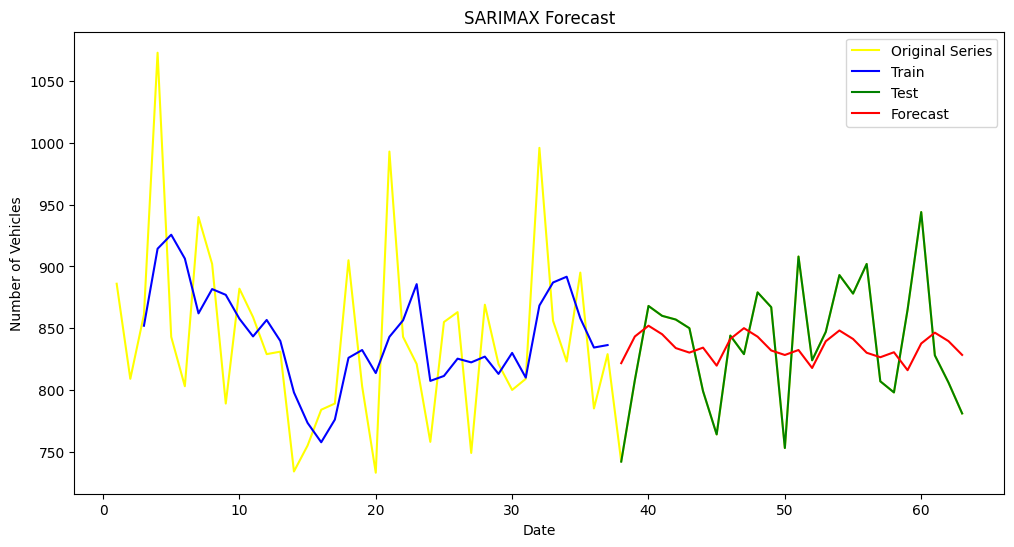

In [20]:

# Train-test split
train_size = int(0.6 * len(daily_counts)) # day_counts is only 63 data long T-T
train, test = daily_counts[:train_size], daily_counts[train_size:]
org_train = train

# Calculate the moving average with a window size of 3
train = train.rolling(window=3).mean()

# Fit the SARIMAX model
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))  # Adjust parameters as needed
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Calculate MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculate MASE
mase = mean_absolute_scaled_error(test, forecast, y_train=org_train)

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
series.plot(label='Original Series', color='yellow')
train.plot(label='Train', color='b')
test.plot(label='Test', color='g')
forecast.index = test.index  # Align forecast index
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("SARIMAX Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()



#### PART 1C (For predicting average time spent)

##### METHOD - Try to match camera records which could not be matched exactly but can be done so with one character mismatch
The values of MAPE and MASE have changed as follows:

In [21]:

data=pd.read_csv("parkingLot.csv")

# Strip whitespaces and replace empty strings with NaN
data_pro = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
data_pro.replace('', np.nan, inplace=True)
data_pro.columns=data_pro.columns.str.strip()

data_pro['date']=data_pro['timestamp'].apply(lambda x: x[:11])
data_pro['#date']=pd.Categorical(data_pro['date']).codes+1
data_pro['#week']=(data_pro['#date']-1)//7 +1
data_pro=data_pro[data_pro['#week']!=10] # drop the day 64, 12 AM data()

data_pro['time']=data_pro['timestamp'].apply(lambda x: x[11:])
data_pro['time']=pd.to_timedelta(data_pro['time']).dt.total_seconds()/3600
data_pro=data_pro[data_pro['time']>=5]
data_pro=data_pro[data_pro['time']<=24]

print("dataframe shape without preprocessing:", data_pro.shape)
dropped_rows = data_pro[data_pro.isnull().any(axis=1)]
data_pro = data_pro.dropna(axis=0)
print("dataframe shape with null values removed:", data_pro.shape)
print("rows containing null values:", dropped_rows.shape)

print("\nworking with the non-null rows hereafter\n")

data_entry=data_pro[data_pro['camera_id']==1]
data_exit=data_pro[data_pro['camera_id']==2]

# Merging the data w.r.t vehicle_no. for calculating average time spent etc.
### In the process many data are lost, we try to improve upon this

entries = data_entry.rename(columns={'time': 'entry_time'})
exits = data_exit.rename(columns={'time': 'exit_time'})
merged_data = pd.merge(entries, exits, on=['vehicle_no','date'], how='outer', indicator=True)

# Capture dropped rows from both DataFrames
dropped_from_entries = merged_data[merged_data['_merge'] == 'left_only']
dropped_from_exits = merged_data[merged_data['_merge'] == 'right_only']
merged_data = merged_data[merged_data['_merge'] == 'both']

print("rows in entry data: ", entries.shape)
print("rows in exit data: ", exits.shape)
print("\ndoing the merge")
print("rows dropped from entry data: ", dropped_from_entries.shape)
print("rows dropped from exit data: ", dropped_from_exits.shape)
print("rows in merged_data: ", merged_data.shape)


dataframe shape without preprocessing: (105439, 7)
dataframe shape with null values removed: (104998, 7)
rows containing null values: (441, 7)

working with the non-null rows hereafter

rows in entry data:  (52976, 7)
rows in exit data:  (52022, 7)

doing the merge
rows dropped from entry data:  (1829, 13)
rows dropped from exit data:  (874, 13)
rows in merged_data:  (51152, 13)


In [22]:

dropped_from_entries = dropped_from_entries[['vehicle_no', '#date_x', 'entry_time']]
dropped_from_entries = dropped_from_entries.sort_values(by=['#date_x', 'entry_time'])

dropped_from_exits = dropped_from_exits[['vehicle_no', '#date_y', 'exit_time']]
dropped_from_exits = dropped_from_exits.sort_values(by = ['#date_y', 'exit_time'])

In [23]:

def is_one_character_mismatch(str1, str2):
    # Check if the lengths of the strings are the same
    if len(str1) != len(str2):
        return False
    
    # Count mismatches
    mismatches = sum(1 for a, b in zip(str1, str2) if a != b)
    
    # Return True if there is exactly one mismatch
    return mismatches == 1

new_data = pd.DataFrame(['vehicle_no1', 'vehicle_no2', 'time_spent', '#day'])

for index1, row1 in dropped_from_exits.iterrows():
    for index2, row2 in dropped_from_entries.iterrows():
        if(row1['#date_y']==row2['#date_x'] and row1['exit_time']>row2['entry_time'] and 
           is_one_character_mismatch(row1['vehicle_no'],row2['vehicle_no'])):
            new_row = pd.DataFrame({'vehicle_no1':[row1['vehicle_no']], 'vehicle_no2':[row2['vehicle_no']], 'time_spent':[row1['exit_time']-row2['entry_time']], '#day':[row1['#date_y']]})
            new_data = pd.concat([new_data,new_row], ignore_index=True)
            dropped_from_entries = dropped_from_entries.drop(index=index2)
            dropped_from_exits = dropped_from_exits.drop(index = index1)

In [24]:

new_data = new_data[['vehicle_no1', 'vehicle_no2', 'time_spent', '#day']]
new_data = new_data[4:]

print('data rows for which there was a match: ', new_data.shape)
print('data in entries for which there wasnt a match: ', dropped_from_entries.shape)
print('data in exits for which there wasnt a match: ', dropped_from_exits.shape)

new_data.reset_index(drop=True)
new_data.to_csv('merged.csv')

data rows for which there was a match:  (504, 4)
data in entries for which there wasnt a match:  (1325, 3)
data in exits for which there wasnt a match:  (370, 3)


In [25]:

# Finding time spent in mall
merged_data['time_spent'] = merged_data['exit_time'] - merged_data['entry_time']

merged_data = merged_data.groupby('#date_x')['time_spent'].agg(['sum', 'count']).reset_index()
new_data = new_data.groupby('#day')['time_spent'].agg(['sum', 'count']).reset_index()

merged_data.rename(columns={'#date_x': '#day'}, inplace=True)

In [26]:

combined = new_data + merged_data
combined['#day'] = combined['#day']/2
combined['avg'] = combined['sum']/combined['count']
avg_count = combined['avg']
combined

,#day,sum,count,avg
0,1.0,3653.000000,868,4.208525
1,2.0,5088.333333,787,6.465481
2,3.0,6922.333333,841,8.231074
3,4.0,9246.000000,1033,8.950629
4,5.0,6880.666667,819,8.401302
...,...,...,...,...
58,59.0,4324.000000,840,5.147619
59,60.0,4418.666667,927,4.766631
60,61.0,3791.000000,811,4.674476
61,62.0,3815.333333,790,4.829536


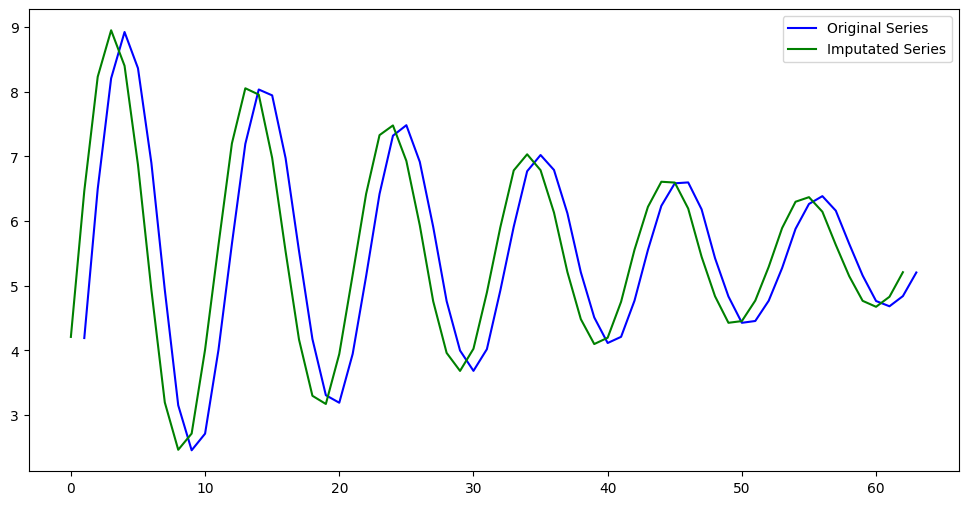

In [27]:

plt.figure(figsize=(12, 6))
plt.plot(average_time,label='Original Series', color='blue')
plt.plot(avg_count, label='Imputated Series', color='green')
plt.legend()
plt.show()

c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE:  0.036404068102235954
MASE:  0.20569967708312475


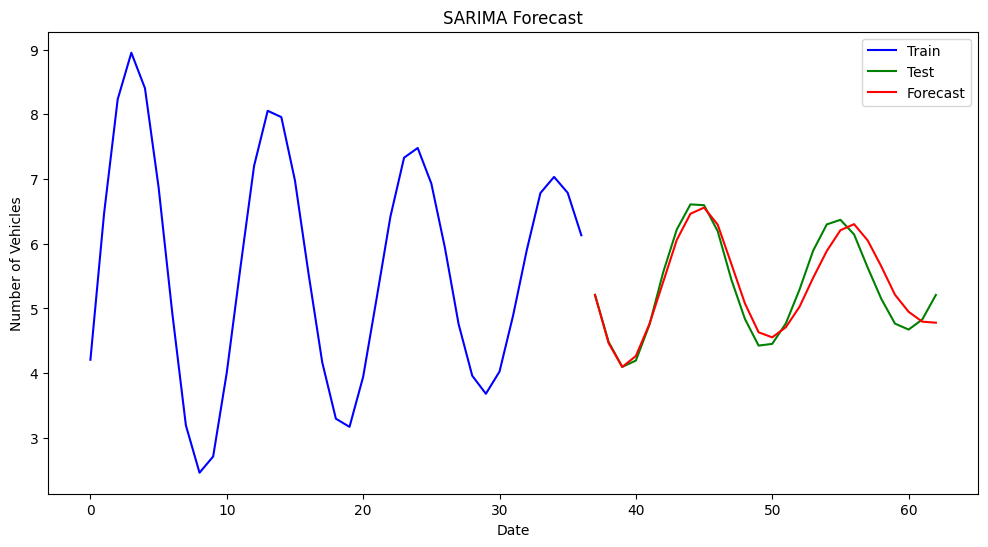

In [28]:

series = avg_count

# Apply Box-Cox Transformation to stabilize variance
# Adding a small constant to avoid zero or negative values
transformed_series, lambda_ = boxcox(series)

# Create a new Series for the transformed data
transformed_series = pd.Series(transformed_series)

# Train-test split
train_size = int(0.6 * len(transformed_series)) # day_counts is only 63 data long T-T
train, test = transformed_series[:train_size], transformed_series[train_size:]

# Fit the Sesonal ARIMA model with sesonality of 10
model = SARIMAX(train, order=(3, 0, 1), seasonal_order=(1, 0, 1, 10))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

forecast = inverse_boxcox(forecast, lambda_) # Reverse the Box-Cox transformation

# Calculate MAPE
mape = mean_absolute_percentage_error(series[train_size:], forecast)

# Calculate MASE 
mase = mean_absolute_scaled_error(series[train_size:], forecast, y_train=series[:train_size])

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
series[:train_size].plot(label='Train', color='b')
series[train_size:].plot(label='Test', color='g')
forecast.index = test.index 
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()




##### METHOD - Try to match the remaining entry and exit items with the null values 
The values of MAPE and MASE have changed as follows:

In [29]:

dropped_rows = dropped_rows[['vehicle_no', '#date', 'time', 'camera_id']]
dropped_rows_1 = dropped_rows[dropped_rows["camera_id"]==1]
dropped_rows_2 = dropped_rows[dropped_rows["camera_id"]==2]

data_mod = pd.DataFrame(['vehicle_no1', 'time_spent', '#day'])

for index1, row1 in dropped_rows_2.iterrows():
    for index2, row2 in dropped_from_entries.iterrows():
        if(row1['#date']==row2['#date_x'] and row1['time']>row2['entry_time']):
            new_row = pd.DataFrame({'vehicle_no':[row2['vehicle_no']], 'time_spent':[row1['time']-row2['entry_time']], '#day':[row2['#date_x']]})
            data_mod = pd.concat([data_mod,new_row], ignore_index=True)
            try:
                dropped_from_entries = dropped_from_entries.drop(index = index2)
                dropped_rows_2 = dropped_rows_2.drop(index = index1)
            except:
                pass

for index1, row1 in dropped_rows_1.iterrows():
    for index2, row2 in dropped_from_exits.iterrows():
        if(row1['#date']==row2['#date_y'] and row1['time']<row2['exit_time']):
            new_row = pd.DataFrame({'vehicle_no':[row2['vehicle_no']], 'time_spent':[row2['exit_time']-row1['time']], '#day':[row2['#date_y']]})
            data_mod = pd.concat([data_mod,new_row], ignore_index=True)
            try:
                dropped_from_exits = dropped_from_exits.drop(index = index2)
                dropped_rows_1 = dropped_rows_1.drop(index = index1)
            except:
                pass


In [30]:
data_mod


,0,vehicle_no,time_spent,#day
0,vehicle_no1,NaN,NaN,NaN
1,time_spent,NaN,NaN,NaN
2,#day,NaN,NaN,NaN
3,NaN,MHBU8023,4.000000,10.0
4,NaN,MHBX5558,4.000000,10.0
...,...,...,...,...
438,NaN,MHAS6887,6.333333,59.0
439,NaN,MHCE0253,6.333333,59.0
440,NaN,MHGL1365,6.333333,59.0
441,NaN,MHMJ2863,6.333333,59.0


In [31]:
data_mod=data_mod[3:].reset_index()
data_mod2 = data_mod.groupby('#day')['time_spent'].agg(['sum', 'count']).reset_index()
print(data_mod2)

combined.drop(columns=['avg'], inplace=True)

# Merge the data on 'day'
combined2 = pd.merge(combined, data_mod2, on='#day', how='left', suffixes=('', '_new'))

# Fill NaN values with 0 for non-matching rows
combined2[['sum_new', 'count_new']] = combined2[['sum_new', 'count_new']].fillna(0)

# Add the sums and counts
combined2['sum'] = combined2['sum'] + combined2['sum_new']
combined2['count'] = combined2['count'] + combined2['count_new']

# Calculate the new average
combined2['avg'] = combined2['sum'] / combined2['count']

# Drop unnecessary columns
combined2 = combined2[['#day', 'sum', 'count', 'avg']]

print(combined2)

   #day         sum  count
0   3.0  541.000000     64
1  10.0  195.666667     69
2  17.0  235.000000     42
3  24.0  342.666667     45
4  31.0  247.666667     61
5  38.0  169.333333     32
6  45.0  237.333333     35
7  52.0  230.333333     46
8  59.0  240.666667     46
    #day          sum   count       avg
0    1.0  3653.000000   868.0  4.208525
1    2.0  5088.333333   787.0  6.465481
2    3.0  7463.333333   905.0  8.246777
3    4.0  9246.000000  1033.0  8.950629
4    5.0  6880.666667   819.0  8.401302
..   ...          ...     ...       ...
58  59.0  4564.666667   886.0  5.151994
59  60.0  4418.666667   927.0  4.766631
60  61.0  3791.000000   811.0  4.674476
61  62.0  3815.333333   790.0  4.829536
62  63.0  3964.333333   761.0  5.209374

[63 rows x 4 columns]


c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE:  0.02217562701938454
MASE:  0.11980024624773912


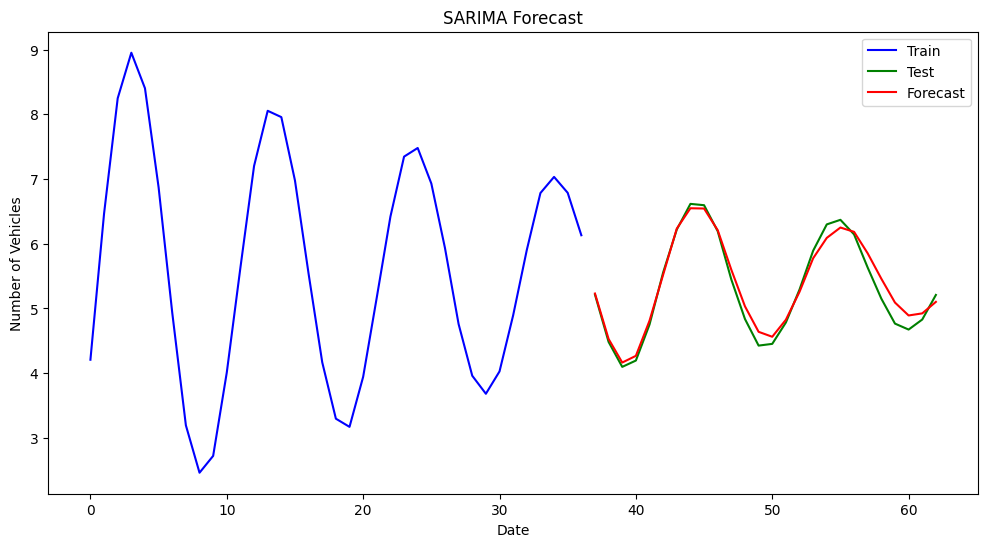

In [32]:

series = combined2['avg']

# Apply Box-Cox Transformation to stabilize variance
# Adding a small constant to avoid zero or negative values
transformed_series, lambda_ = boxcox(series)

# Create a new Series for the transformed data
transformed_series = pd.Series(transformed_series)

# Train-test split
train_size = int(0.6 * len(transformed_series)) # day_counts is only 63 data long T-T
train, test = transformed_series[:train_size], transformed_series[train_size:]

# Fit the Sesonal ARIMA model with sesonality of 10
model = SARIMAX(train, order=(3, 0, 2), seasonal_order=(1, 0, 1, 10))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

forecast = inverse_boxcox(forecast, lambda_) # Reverse the Box-Cox transformation

# Calculate MAPE
mape = mean_absolute_percentage_error(series[train_size:], forecast)

# Calculate MASE 
mase = mean_absolute_scaled_error(series[train_size:], forecast, y_train=series[:train_size])

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
series[:train_size].plot(label='Train', color='b')
series[train_size:].plot(label='Test', color='g')
forecast.index = test.index 
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()